In [9]:
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from tqdm import tqdm

from datasets import load_dataset # Added this line

# Load the COCO dataset using Hugging Face datasets library
# This will automatically handle caching and memory-efficient loading.
# We are loading the 'train' split as an example.
print("Loading COCO dataset from Hugging Face Hub...")
dataset = load_dataset("detection-datasets/coco", split="train")
print("Dataset loaded successfully!")


# Placeholder for coco_data structure for initial compatibility.
# This will be populated by iterating through the dataset.
coco_data = {
    'images': [],
    'annotations': [],
    'categories': []
}

Loading COCO dataset from Hugging Face Hub...
Dataset loaded successfully!


In [5]:

# To get categories, we might need to inspect the dataset features or load them separately.
# For now, let's assume we can extract them from the first few samples or from dataset info.
# A more robust solution would involve getting the features from dataset.features['objects'].feature['category'].names
# For now, let's create a dummy category list and then populate it properly.
# This part needs careful handling as 'datasets' might not expose categories in the same way.
# Let's try to get categories from the dataset features.
category_names = dataset.features['objects']['category'].feature.names
coco_data['categories'] = [{'id': i, 'name': name} for i, name in enumerate(category_names)]

image_id_counter = 0
annotation_id_counter = 0

# Iterate through the dataset to populate images and annotations
for item in tqdm(dataset, desc="Processing dataset items"):
    image_info = {
        'id': image_id_counter,
        'file_name': item['image'].filename if hasattr(item['image'], 'filename') else f"image_{image_id_counter}.jpg",
        'width': item['image'].width,
        'height': item['image'].height
    }
    coco_data['images'].append(image_info)

    for i in range(len(item['objects']['bbox'])):
        bbox = item['objects']['bbox'][i]
        category_id = item['objects']['category'][i]
        
        # Convert bbox from [x_min, y_min, x_max, y_max] to [x, y, width, height] if necessary
        # Hugging Face datasets for COCO typically provide [x_min, y_min, x_max, y_max]
        # The original script expects [x, y, width, height]
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        annotation = {
            'id': annotation_id_counter,
            'image_id': image_id_counter,
            'category_id': category_id,
            'bbox': [x_min, y_min, width, height], # Ensure this format
            'area': width * height,
            'iscrowd': 0 # Assuming not crowd for simplicity
        }
        coco_data['annotations'].append(annotation)
        annotation_id_counter += 1
    image_id_counter += 1

print("Annotations loaded successfully!")

print("\n## Dataset Statistics")
# Basic counts
num_images = len(coco_data['images'])
num_annotations = len(coco_data['annotations'])
num_categories = len(coco_data['categories'])

print(f"Number of images: {num_images}")
print(f"Number of annotations: {num_annotations}")
print(f"Number of categories: {num_categories}")

print("\n### Category Distribution")

Processing dataset items: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117266/117266 [03:33<00:00, 550.33it/s]

Annotations loaded successfully!

## Dataset Statistics
Number of images: 117266
Number of annotations: 860001
Number of categories: 80

### Category Distribution


Counting categories: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 860001/860001 [00:00<00:00, 2078557.39it/s]


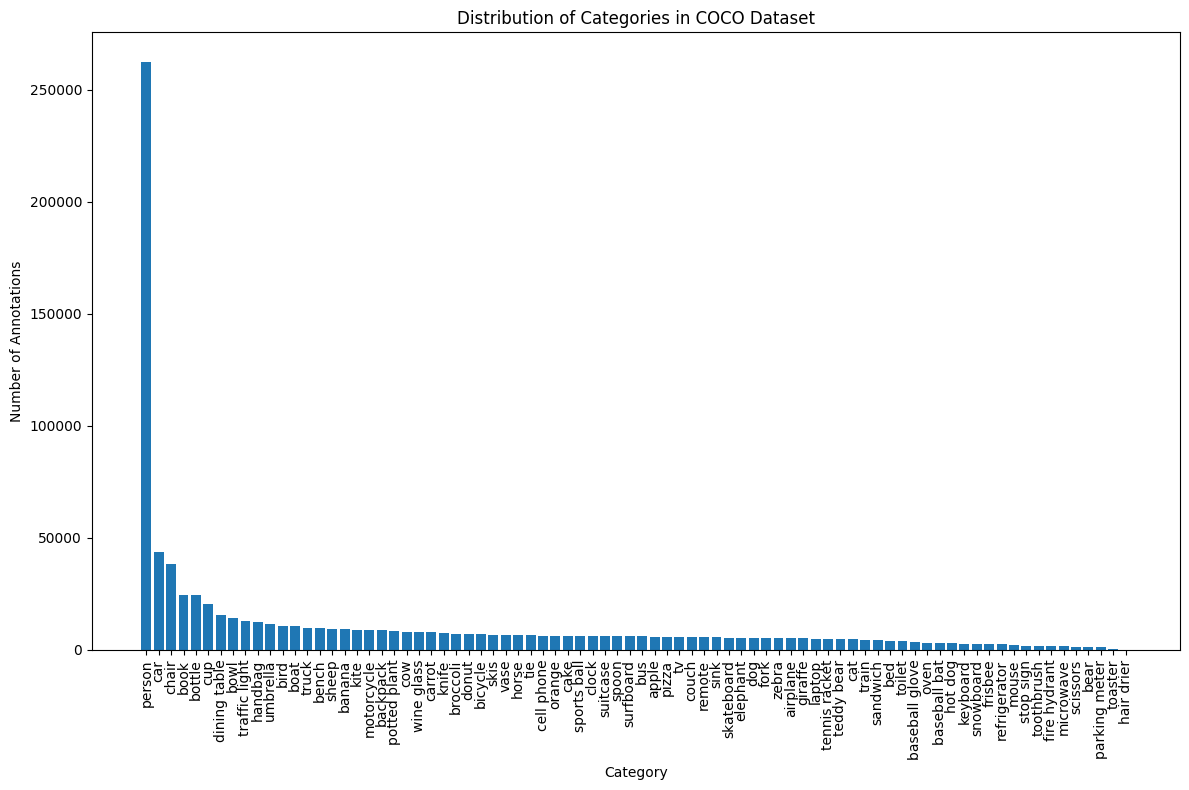


### Objects per Image Distribution


In [6]:
category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
category_counts = defaultdict(int)

for ann in tqdm(coco_data['annotations'], desc="Counting categories"):
    category_counts[ann['category_id']] += 1

sorted_categories = sorted(category_counts.items(), key=lambda item: item[1], reverse=True)

labels = [category_id_to_name[cat_id] for cat_id, _ in sorted_categories]
counts = [count for _, count in sorted_categories]

plt.figure(figsize=(12, 8))
plt.bar(labels, counts)
plt.xlabel('Category')
plt.ylabel('Number of Annotations')
plt.title('Distribution of Categories in COCO Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("\n### Objects per Image Distribution")


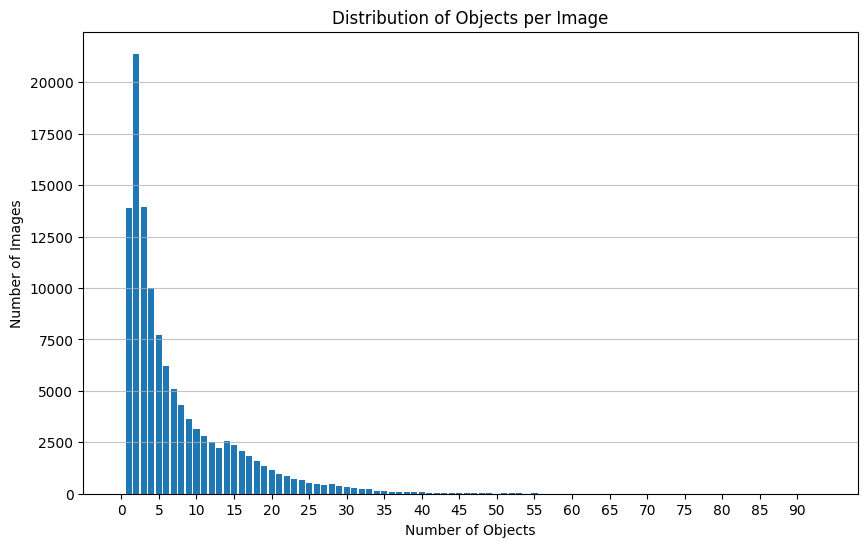


### Bounding Box Size Distribution


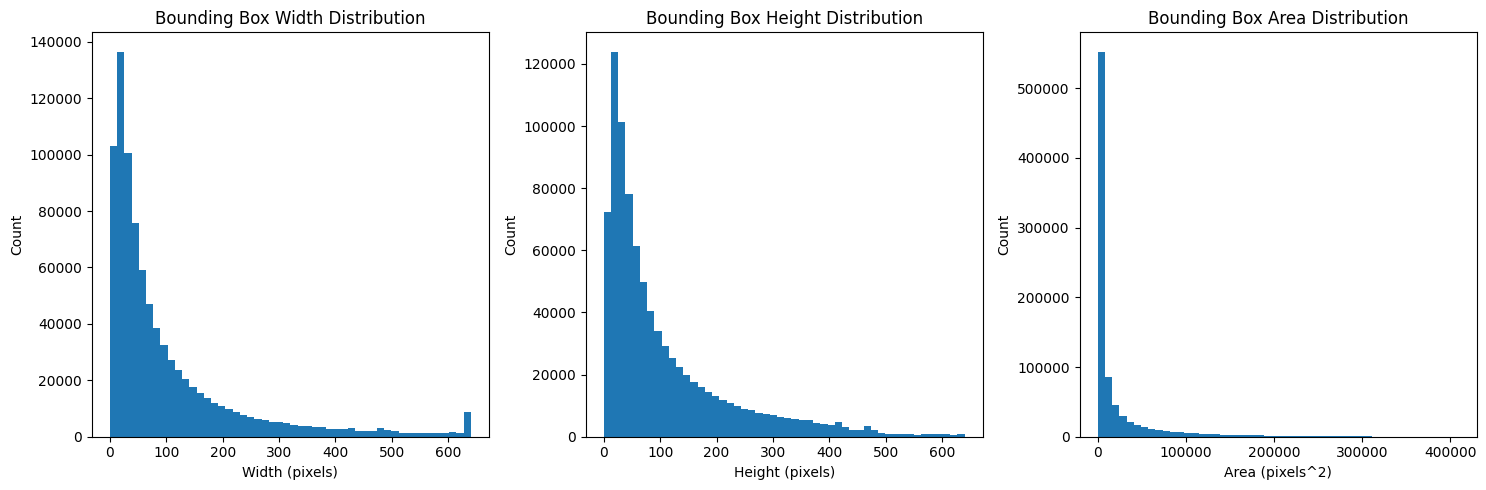


## Visualize Bounding Boxes


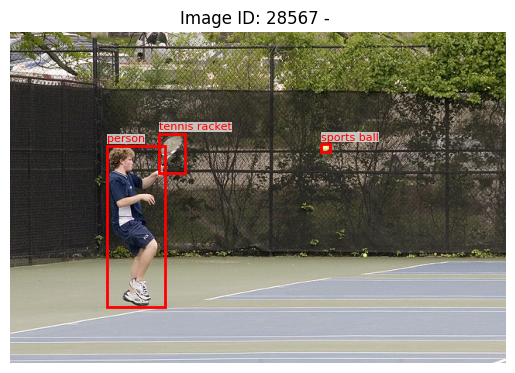

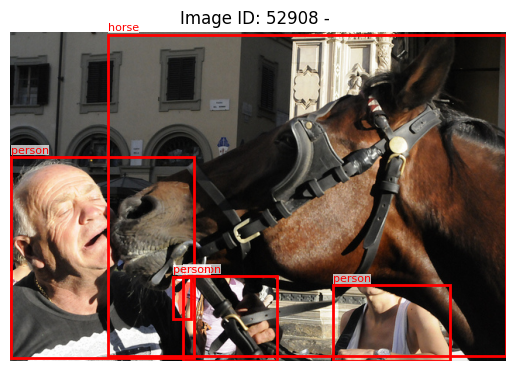

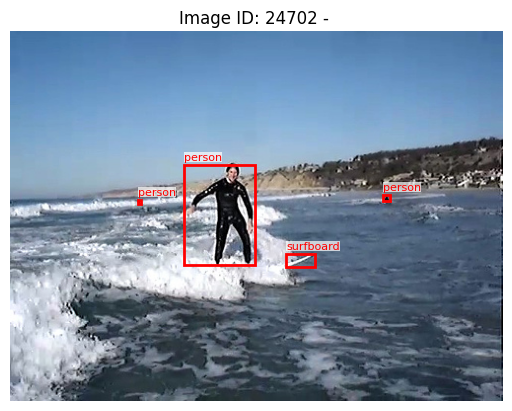

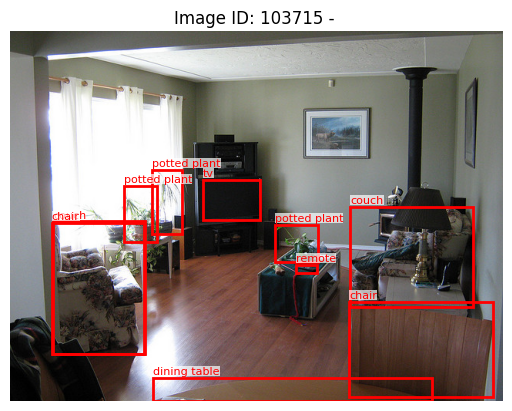

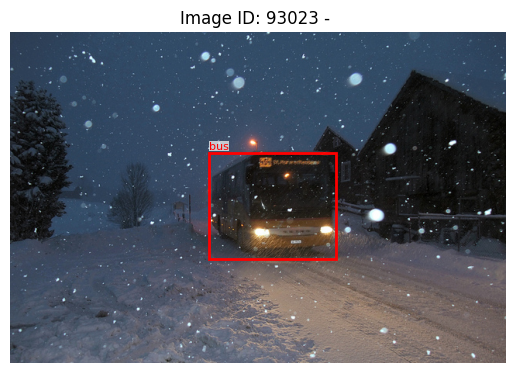

In [7]:
image_id_to_annotations = defaultdict(list)
for ann in coco_data['annotations']:
    image_id_to_annotations[ann['image_id']].append(ann)

objects_per_image = [len(anns) for anns in image_id_to_annotations.values()]

plt.figure(figsize=(10, 6))
plt.hist(objects_per_image, bins=range(max(objects_per_image) + 2), align='left', rwidth=0.8)
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')
plt.title('Distribution of Objects per Image')
plt.xticks(range(0, max(objects_per_image) + 1, 5)) # Adjust x-ticks for better readability
plt.grid(axis='y', alpha=0.75)
plt.show()

print("\n### Bounding Box Size Distribution")
bbox_widths = []
bbox_heights = []
bbox_areas = []

for ann in tqdm(coco_data['annotations'], desc="Collecting bbox sizes"):
    bbox = ann['bbox'] # [x, y, width, height]
    bbox_widths.append(bbox[2])
    bbox_heights.append(bbox[3])
    bbox_areas.append(bbox[2] * bbox[3])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(bbox_widths, bins=50)
plt.title('Bounding Box Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(bbox_heights, bins=50)
plt.title('Bounding Box Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(bbox_areas, bins=50)
plt.title('Bounding Box Area Distribution')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("\n## Visualize Bounding Boxes")
def visualize_image_with_bboxes(image_info, pil_image, annotations, category_id_to_name):
    fig, ax = plt.subplots(1)
    ax.imshow(pil_image)

    for ann in annotations:
        if ann['image_id'] == image_info['id']:
            bbox = ann['bbox'] # [x, y, width, height]
            x, y, w, h = bbox
            category_name = category_id_to_name[ann['category_id']]

            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y - 5, category_name, color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0))

    plt.axis('off')
    plt.title(f"Image ID: {image_info['id']} - {image_info['file_name']}")
    plt.show()

# Select a few random images to visualize
import random

# Ensure there are enough images to sample from
dataset_indices = list(range(len(dataset)))
if len(dataset_indices) >= 5:
    sampled_indices = random.sample(dataset_indices, 5)
else:
    sampled_indices = dataset_indices

for idx in sampled_indices:
    image_info_from_coco_data = coco_data['images'][idx]
    pil_image = dataset[idx]['image']
    visualize_image_with_bboxes(image_info_from_coco_data, pil_image, coco_data['annotations'], category_id_to_name)
